## We choose a window of 60 time steps
## We want to learn 59 steps and predict 1 steps.
## Each step = 1 second

In [134]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(4597200, 6)


pos.x     pos.y     pos.z   heading  velocity  weather
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2

In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [8]:
data.head()

pos.x     pos.y     pos.z   heading  velocity  weather    Minute sin  \
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2 -1.792514e-08   
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2  1.045284e-01   
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2  2.079117e-01   
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2  3.090170e-01   
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2  4.067366e-01   

   Minute cos  
0    1.000000  
1    0.994522  
2    0.978148  
3    0.951057  
4    0.913545

In [9]:
data = data.head(705660)

### Windowing
We choose a window of 60 time steps
We want to learn 59 steps and predict 1 steps.

In [10]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [11]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

11761
60
8


### Slice and Split sequence 

In [12]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [13]:
x_train_init.shape, x_test_init.shape

((9408, 60, 8), (2353, 60, 8))

In [14]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence(x_train_init)

In [15]:
x_train.shape, y_train.shape

((9408, 59, 8), (9408, 1, 8))

In [16]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [17]:
y_train.shape

(9408, 1, 2)

In [18]:
y_train = y_train.reshape((-1, y_train.shape[-1]))

In [19]:
y_train.shape

(9408, 2)

In [20]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence(x_test_init)

In [21]:
x_test.shape, y_test.shape

((2353, 59, 8), (2353, 1, 8))

In [22]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [23]:
y_test.shape

(2353, 1, 2)

In [24]:
y_test = y_test.reshape((-1, y_test.shape[-1]))

In [25]:
y_test.shape

(2353, 2)

### Model Configuration

In [26]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(59, 8)

In [27]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(2,)

In [28]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 1
output_features_nr=y_train_feature_nr * output_seq_size
output_features_nr

2

### Train and evaluate

In [32]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [33]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_nr, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [34]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
236/236 [==============================] - 24s 90ms/step - loss: 2749.1633 - mae: 33.2733 - val_loss: 268.3853 - val_mae: 10.2556 - lr: 0.0010
Epoch 2/100
236/236 [==============================] - 23s 96ms/step - loss: 606.6365 - mae: 17.7560 - val_loss: 238.7808 - val_mae: 9.4426 - lr: 0.0010
Epoch 3/100
236/236 [==============================] - 21s 90ms/step - loss: 532.0752 - mae: 16.5370 - val_loss: 231.3598 - val_mae: 8.7336 - lr: 0.0010
Epoch 4/100
236/236 [==============================] - 22s 93ms/step - loss: 493.0722 - mae: 15.8116 - val_loss: 231.0320 - val_mae: 8.7686 - lr: 0.0010
Epoch 5/100
236/236 [==============================] - 23s 96ms/step - loss: 465.8373 - mae: 15.4198 - val_loss: 249.7327 - val_mae: 9.4314 - lr: 0.0010
Epoch 6/100
236/236 [==============================] - 24s 102ms/step - loss: 472.9609 - mae: 15.4250 - val_loss: 230.4332 - val_mae: 8.5973 - lr: 0.0010
Epoch 7/100
236/236 [==============================] - 24s 100ms/step - loss: 4

In [ ]:
#model.summary()

In [29]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

74/74 [==============================] - 3s 29ms/step - loss: 186.6751 - mae: 8.8953
Test accuracy 8.895284652709961
Test loss 186.67506408691406


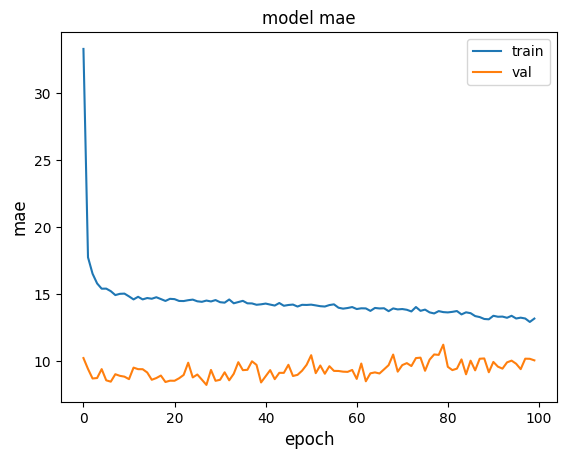

In [36]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [30]:
predictions = model.predict(x_test)

74/74 [==============================] - 2s 28ms/step


In [31]:
predictions.shape

(2353, 2)

Visualize some few predictions


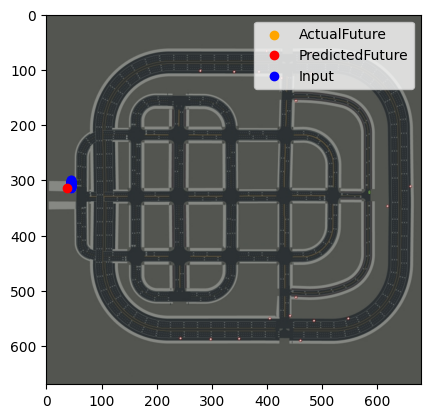

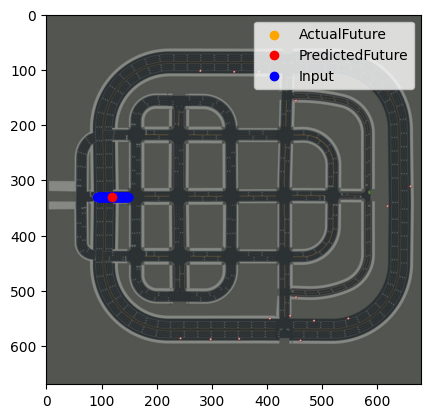

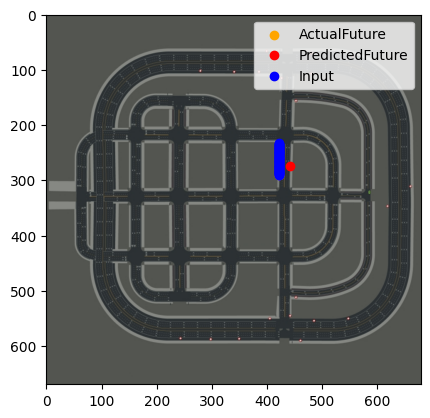

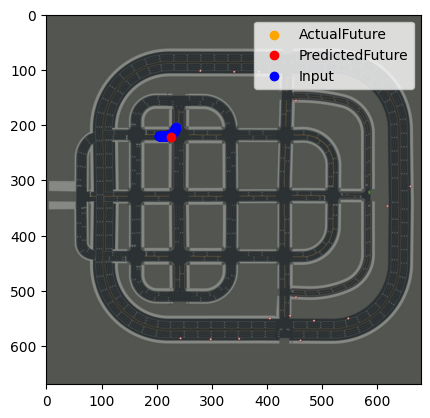

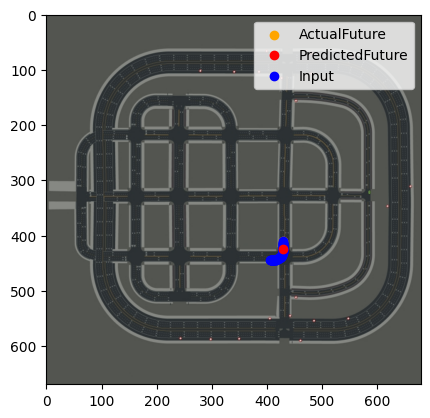

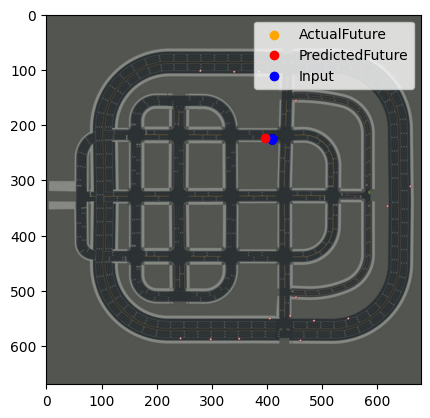

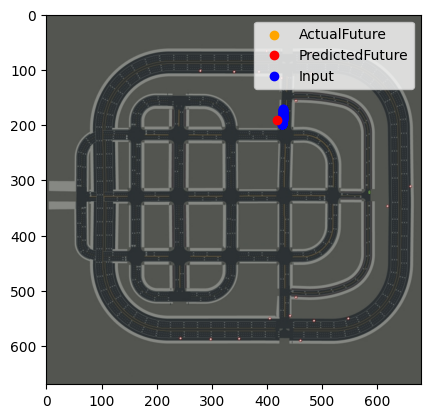

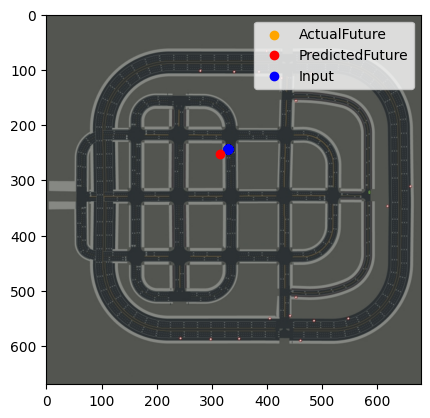

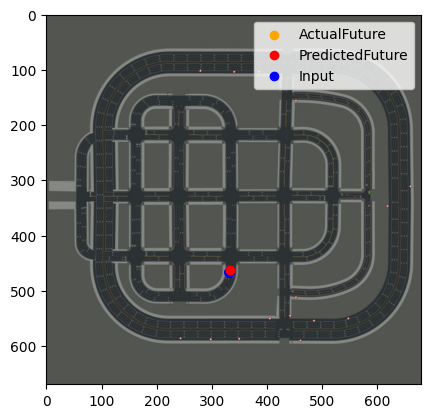

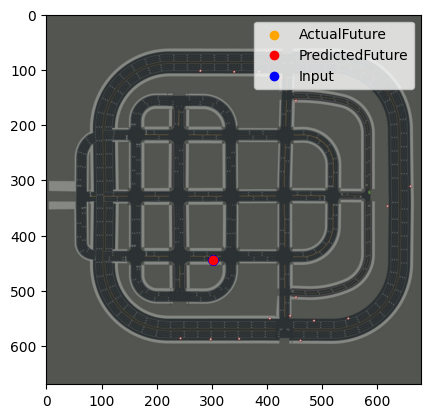

In [39]:
import random
from configs.utils_2 import plot_pred


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test))
        plot_pred(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

In [32]:
from explainers.explainer import BlackBoxWrapper, ITPFExplainer

blackbox = BlackBoxWrapper(model=model, isMultivariate=True)
explainer = ITPFExplainer()
explainer.fit_exp(model=blackbox, x=x_train, y=y_train, feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], class_names=['pos.x', 'pos.y'])

In [33]:
y=x_test[0]

### LIME

In [34]:
explainer.lime(y=y, labelId=0)

(5000, 59, 8)
157/157 [==============================] - 4s 25ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


In [35]:
explainer.lime(y=y, labelId=1)

(5000, 59, 8)
157/157 [==============================] - 4s 27ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


### Shap

In [53]:
y.shape

(59, 8)

In [36]:
explainer.shap(y)

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/59 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


ValueError: cannot reshape array of size 2 into shape (7434,2)

### Shap Adaptive

In [37]:
y.shape

(59, 8)

In [135]:
baseline_tab = explainer.baseline_extra(y)

In [124]:
baseline_tab.shape

(59, 8)

In [42]:
import numpy as np
import itertools
import sys

In [144]:
from scipy.special import comb
import math

def compute_weight(total_features, subset_size):
    """
    Computes the weight for subsets of a given size in the context of Shapley values.
    
    Parameters:
    - total_features: Total number of features (|N|).
    - subset_size: Size of the subset including the feature (|S|).
    
    Returns:
    - The weight for the subset.
    """
    return (math.factorial(subset_size - 1) * math.factorial(total_features - subset_size)) / math.factorial(total_features)

# Example usage
total_features = 8  # Total number of features
subset_size = 1  # Size of the subset including the feature of interest

weight = compute_weight(total_features, subset_size)
print(f"Weight for subset of size {subset_size} (out of {total_features}): {weight}")


Weight for subset of size 1 (out of 8): 0.125


In [145]:
from itertools import product


def create_mask(feature_num):
    mask = np.array(list(product(range(2), repeat=feature_num)))
    mask = mask[~np.all(mask == 0, axis=1)]
    mask = mask[~np.all(mask == 1, axis=1)]
  
    return mask

In [146]:
def value_function(feature, feature_num, y, model):
    # create array mask
    mask=create_mask(feature_num)

    # configuration and baseline
    marginal_contribution = []
    average_contribution = []
    data = y
    baseline_tab = explainer.baseline_extra(data)
    n_features = data.shape[1]
    baseline_pred = model.predict_2Dto3D(baseline_tab)
    original_pred = model.predict_2Dto3D(data)

    # compute marginal contribution for baseline {feature} - {}
    weight = compute_weight(feature_num, 1)
    pred = weight*(original_pred - baseline_pred)
    marginal_contribution.append(pred)
    # compute marginal contribution

    for item in mask:
        # Initialize arrays as copies of data and baseline_tab
        without_feature = baseline_tab.copy()
        with_feature = baseline_tab.copy()
        number_of_feature_masked = 0
        
        # Iterate over each element in the mask
        for i, use_data in enumerate(item):
            if use_data:
                without_feature[:, i] = data[:, i]
                with_feature[:, i] = data[:, i]
                number_of_feature_masked = number_of_feature_masked + 1

        # Include the feature
        with_feature[:, feature] = data[:, feature]
        number_of_feature_masked = number_of_feature_masked + 1
        weight = compute_weight(feature_num, number_of_feature_masked)
       

        # compute marginal contribution
        pred_without_feature = model.predict_2Dto3D(without_feature)
        pred_with_feature = model.predict_2Dto3D(with_feature)
        pred = weight*(pred_with_feature - pred_without_feature)
        marginal_contribution.append(pred)
    
    # compute the average contribution
    marginal_contributions1_reshape = np.array([a.reshape(1, -1) for a in marginal_contribution])
    marginal_contribution_combined = np.vstack(marginal_contributions1_reshape)
    average_contribution = np.mean(marginal_contribution_combined, axis=0)
    return average_contribution


In [147]:
def shap_values_multivariate(model, y):
    # step 1: Get the baseline and configuration
    n_features = y.shape[1]
    n_feature_pred = 2
    shapley_values = np.zeros((n_feature_pred, n_features))
    # step 2: Compute the shapeley values for each feature
    for feature in range(n_features):
        s_value = value_function(feature, n_features, y, model)
        print("Feature ", feature, " values: ", s_value)
        # Load values
        for p in range(n_feature_pred):
            shapley_values[p][feature] = s_value[p]
    return shapley_values

In [148]:
values = shap_values_multivariate(blackbox, y)

(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 22ms/step
(1, 59, 8)
1/1 [==============================] - 0s 17ms/step
(1, 59, 8)
1/1 [==============================] - 0s 18ms/step
(1, 59, 8)
1/1 [==============================] - 0s 16ms/step
(1, 59, 8)
1/1 [==============================] - 0s 17ms/step
(1, 59, 8)
1/1 [==============================] - 0s 20ms/step
(1, 59, 8)
1/1 [==============================] - 0s 17ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 32ms/step
(1, 59, 8)
1/1 [==============================] - 0s 16ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 16

In [149]:
values

array([[-0.2308775 , -0.05085153, -0.04750765, -0.03340758, -0.04408085,
        -0.03753877, -0.04312371, -0.05174536],
       [ 0.13418123,  0.10231278,  0.00884587,  0.02774547,  0.00216859,
         0.01068314,  0.01889304,  0.01692866]])

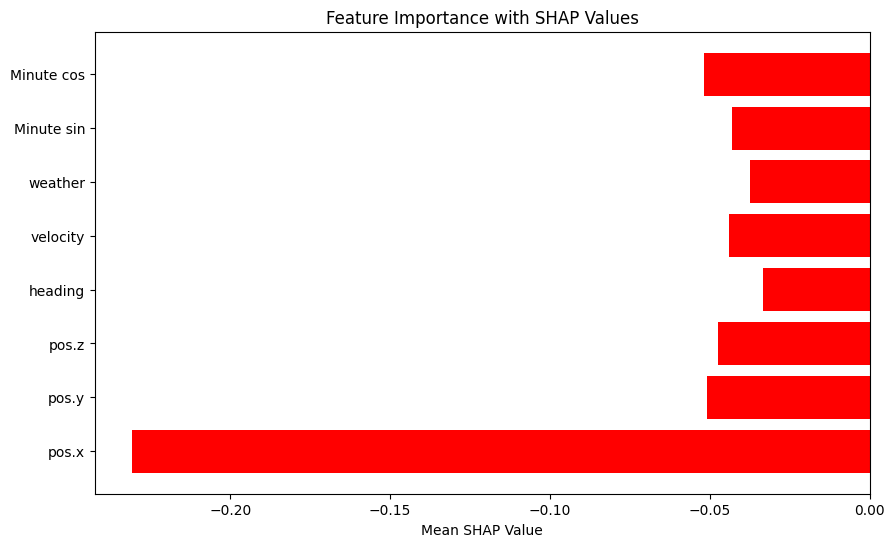

In [161]:
import matplotlib.pyplot as plt
import numpy as np


num_features = 8
shap_values = values[0]  # Your actual Shapley values
feature_names = ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"]

# Determine bar colors based on the sign of the mean Shapley values
bar_colors = ['red' if x < 0 else 'blue' for x in shap_values]

# Plot
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, shap_values, align='center', color=bar_colors)
plt.yticks(y_pos, feature_names)
plt.xlabel('Mean SHAP Value')
plt.title('Feature Importance with SHAP Values')
plt.show()



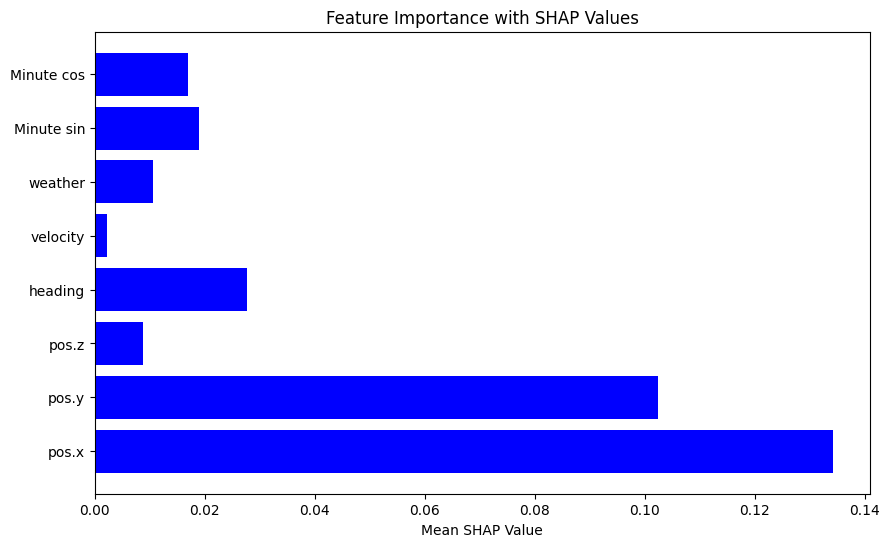

In [162]:
import matplotlib.pyplot as plt
import numpy as np


num_features = 8
shap_values = values[1]  # Your actual Shapley values
feature_names = ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"]

# Determine bar colors based on the sign of the mean Shapley values
bar_colors = ['red' if x < 0 else 'blue' for x in shap_values]

# Plot
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, shap_values, align='center', color=bar_colors)
plt.yticks(y_pos, feature_names)
plt.xlabel('Mean SHAP Value')
plt.title('Feature Importance with SHAP Values')
plt.show()